# Exploring Contextural Bias of ResNet50 on CIFAR10 Dataset

### Introduction

This notebook trains and tests a vanilla ResNet50 model and a stylised ResNet50 model with the CIFAR10 dataset. It includes functions for loading the dataset, turning them into tensors, model training and testing.

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import Conv2d, AvgPool2d
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import os
from skimage import io
import numpy as np
from PIL import Image

### Data Loading

The following cell provides a class that loads the CIFAR dataset given the relevant path, processes it into a dictionary format of class labels and content then processes the images into tensors. The class also has helper functions to extract information about the dataset needed for model training and testing.

In [2]:
class CifarDataset(Dataset):
    
    def __init__(self, data_path):
        
        super(CifarDataset, self).__init__()
        self.data_path = data_path
        self.num_classes = 0
        self.classes = []
        
        classes_list = []
        for class_name in os.listdir(data_path):
            if not os.path.isdir(os.path.join(data_path,class_name)):
                continue
            classes_list.append(class_name)
        classes_list.sort()
        self.classes = [dict(class_idx = k, class_name = v) for k, v in enumerate(classes_list)]
        

        self.num_classes = len(self.classes)

        self.image_list = []
        for cls in self.classes:
            class_path = os.path.join(data_path, cls['class_name'])
            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)
                self.image_list.append(dict(
                    cls = cls,
                    image_path = image_path,
                    image_name = image_name,
                ))

        self.img_idxes = np.arange(0,len(self.image_list))

    def __len__(self):
        return len(self.img_idxes)

    def __getitem__(self, index):

        img_idx = self.img_idxes[index]
        img_info = self.image_list[img_idx]

        img = Image.open(img_info['image_path'])

        tr = transforms.ToTensor()
        img = tr(img)
        tr = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
        img = tr(img)
        return dict(image = img, cls = img_info['cls']['class_idx'], class_name = img_info['cls']['class_name'])

    def get_number_of_classes(self):
        return self.num_classes

    def get_number_of_samples(self):
        return self.__len__()

    def get_class_names(self):
        return [cls['class_name'] for cls in self.classes]

    def get_class_name(self, class_idx):
        return self.classes[class_idx]['class_name']

In [3]:
def get_cifar_datasets(data_path):
    dataset = CifarDataset(data_path)
    return dataset

The data being used for this experiment are normal CIFAR10 dataset and the stylised version of the CIFAR10 dataset created using AdaIN style transfer.

The following cell calls the function created above to load the training, validation and testing datasets of both normal and stylised CIFAR10 and transforms them into data loaders.

In [4]:
# Load normal CIFAR10
data_path_train = "../../cifar/training"
dataset_train = get_cifar_datasets(data_path_train)

data_path_val = "../../cifar/validation/"
dataset_val = get_cifar_datasets(data_path_val)

data_path_test = "../../cifar/testing/"
dataset_test = get_cifar_datasets(data_path_test)

print(f"Number of train samples {dataset_train.__len__()}")
print("Class names are: " + str(dataset_train.get_class_names()))

print(f"Number of val samples {dataset_val.__len__()}")
print("Class names are: " + str(dataset_val.get_class_names()))

print(f"Number of test samples {dataset_test.__len__()}")
print("Class names are: " + str(dataset_test.get_class_names()))

BATCH_SIZE = 32

data_loader_train = DataLoader(dataset_train, BATCH_SIZE, shuffle = True)
data_loader_val = DataLoader(dataset_val, BATCH_SIZE, shuffle = True)
data_loader_test = DataLoader(dataset_test, BATCH_SIZE, shuffle = True)

# Load stylised CIFAR10
data_path_stylised_train = "../../stylised_cifar32/training"
dataset_stylised_train = get_cifar_datasets(data_path_stylised_train)

data_path_stylised_val = "../../stylised_cifar32/validation/"
dataset_stylised_val = get_cifar_datasets(data_path_stylised_val)

data_path_stylised_test = "../../stylised_cifar32/testing/"
dataset_stylised_test = get_cifar_datasets(data_path_stylised_test)

print(f"Number of stylised train samples {dataset_stylised_train.__len__()}")
print("Class names are: " + str(dataset_stylised_train.get_class_names()))

print(f"Number of stylised val samples {dataset_stylised_val.__len__()}")
print("Class names are: " + str(dataset_stylised_val.get_class_names()))

print(f"Number of stylised test samples {dataset_stylised_test.__len__()}")
print("Class names are: " + str(dataset_stylised_test.get_class_names()))

BATCH_SIZE = 32

data_loader_stylised_train = DataLoader(dataset_stylised_train, BATCH_SIZE, shuffle = True)
data_loader_stylised_val = DataLoader(dataset_stylised_val, BATCH_SIZE, shuffle = True)
data_loader_stylised_test = DataLoader(dataset_stylised_test, BATCH_SIZE, shuffle = True)

Number of train samples 36000
Class names are: ['0000000001', '0000000010', '0000000100', '0000001000', '0000010000', '0000100000', '0001000000', '0010000000', '0100000000', '1000000000']
Number of val samples 4000
Class names are: ['0000000001', '0000000010', '0000000100', '0000001000', '0000010000', '0000100000', '0001000000', '0010000000', '0100000000', '1000000000']
Number of test samples 10000
Class names are: ['0000000001', '0000000010', '0000000100', '0000001000', '0000010000', '0000100000', '0001000000', '0010000000', '0100000000', '1000000000']
Number of stylised train samples 216000
Class names are: ['0000000001', '0000000010', '0000000100', '0000001000', '0000010000', '0000100000', '0001000000', '0010000000', '0100000000', '1000000000']
Number of stylised val samples 4000
Class names are: ['0000000001', '0000000010', '0000000100', '0000001000', '0000010000', '0000100000', '0001000000', '0010000000', '0100000000', '1000000000']
Number of stylised test samples 10000
Class name

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Shape of batch['image'] torch.Size([32, 3, 32, 32])
Shape of batch['cls'] torch.Size([32])


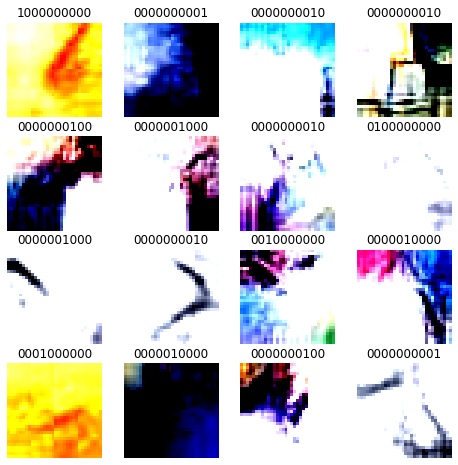

In [5]:
# TODO: Delete before submission
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4,4, figsize=(8, 8))

for batch in data_loader_stylised_train:

    print(f"Shape of batch['image'] {batch['image'].shape}")
    print(f"Shape of batch['cls'] {batch['cls'].shape}")

    for i in range(BATCH_SIZE):
        col = i % 4
        row = i // 4

        img = batch['image'][i].numpy()

        axes[row,col].set_axis_off()
        axes[row,col].set_title(batch['class_name'][i])
        axes[row,col].imshow(np.transpose(img,(1,2,0)))
                         
        if i >= 15:
            break

    plt.show()
    break

### Defining ResNet50

The following code defines Resnet50 architecture that will be used to train and test the CIFAR dataset.

In [6]:
# define resnet building blocks
class ResidualBlock(nn.Module): 
    expansion = 4
    
    def __init__(self, inchannel, outchannel, stride=1): 
        
        super(ResidualBlock, self).__init__() 
        
        self.left = nn.Sequential(
            Conv2d(inchannel, outchannel, kernel_size=1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            Conv2d(outchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            Conv2d(outchannel, self.expansion*outchannel, kernel_size=1, bias=False),
            nn.BatchNorm2d(self.expansion*outchannel)
        ) 
        
        self.shortcut = nn.Sequential()
        
        if stride != 1 or inchannel != self.expansion*outchannel: 
            self.shortcut = nn.Sequential(
                Conv2d(inchannel, self.expansion*outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*outchannel)
            ) 
            
    def forward(self, x): 
        out = self.left(x) 
        out += self.shortcut(x) 
        out = F.relu(out) 
        return out

    
# define resnet
class ResNet(nn.Module):
    
    def __init__(self, ResidualBlock, num_classes = 10):
        
        super(ResNet, self).__init__()
        
        self.inchannel = 64
        self.conv1 = nn.Sequential(
            Conv2d(3, 64, kernel_size = 3, stride = 1,padding = 1, bias = False),
            nn.BatchNorm2d(64), 
            nn.ReLU()
        )
        self.layer1 = self.make_layer(ResidualBlock, 64, 3, stride = 1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 4, stride = 2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 6, stride = 2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 3, stride = 2)
        self.avgpool = AvgPool2d(4)
        self.fc = nn.Linear(512*ResidualBlock.expansion, num_classes)
        
    
    def make_layer(self, block, channels, num_blocks, stride):
        
        strides = [stride] + [1] * (num_blocks - 1)
        
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels * block.expansion
        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    
def ResNet50():
    return ResNet(ResidualBlock)

Following are the training, validation and testing functions for the experiment. train_part() function trains and updates gradients on each batch of the training set and once that is done, it tests its accuracy on the validation set. Every time the validation test returns a better accuracy than the current maximum, the model is saved and carries on with the next epoch. Then it checks with the learning reate scheduler for any changes in learning rate.

In [7]:
device = torch.device('cuda:5' if torch.cuda.is_available() else 'cpu')
    
print(device)
    

print_every = 100
def check_accuracy(loader, model):
    # function for test accuracy on validation and test set
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for i, batch in enumerate(loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs = batch['image'].to(device)
            labels = batch['cls'].to(device)
            scores = model(inputs)
            _, preds = scores.max(1)
            num_correct += (preds == labels).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct, accuracy of the dataset is: %.3f %%' % (num_correct, num_samples, 100 * acc))


def train_part(model, train_data, val_data, model_path, optimizer, lr_scheduler, epochs=1):
    model.to(device)
    val_acc = 0
    num_epoch = 2
    # Main Loop
    for epoch in range(epochs):  # loop over the dataset multiple times
        val_loss = 0
        running_loss = 0

        # Training Loop
        for i, batch in enumerate(train_data, 0):
            # set model to training mode
            model.train()
            # get the inputs; data is a list of [inputs, labels]
            inputs = batch['image'].to(device)
            labels = batch['cls'].to(device)

            # get outputs from the input data and calculate the cross entropy loss
            scores = model(inputs)
            loss = F.cross_entropy(scores, labels)

            # zero and update the gradients and optimise
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 200 == 199:    # print every 200 mini-batches
                print('[%d, %5d] loss: %.6f' %
                      (epoch + 1, i + 1, running_loss / 200))
                running_loss = 0.0

        # set model to evaluation mode
        model.eval()

        # Validation Loop
        with torch.no_grad():
            num_correct = 0
            num_samples = 0
            for i, batch in enumerate(val_data, 0):
                # get the inputs; data is a list of [inputs, labels]
                inputs = batch['image'].to(device)
                labels = batch['cls'].to(device)

                # get the outputs from the model
                outputs = model(inputs)

                # compute accuracy based on the outputs
                _, preds = outputs.max(1)
                num_correct += (preds == labels).sum()
                num_samples += preds.size(0)
            acc = float(num_correct) / num_samples
            print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

            if acc > val_acc:
                print('saving model')
                torch.save(model.state_dict(), model_path)
                val_acc = acc
            else:
                print('skip model saving')
        lr_scheduler.step()

cuda:5


### Vanilla ResNet50 Training

The model used in this experiment is ResNet50 with Adam optimiser with learning rate scheduler and default settings. Learning rate changes every 80, 120, 160, 180th epoch.

In [8]:
torch.cuda.empty_cache()
# starting from 70
# define and train the network
vanilla_model_path = './unstylised_cifar_new.pth'
vanilla_model = ResNet50()
lr=0.1
vanilla_optimizer = optim.Adam(vanilla_model.parameters(), lr=lr)
vanilla_lr_scheduler = optim.lr_scheduler.MultiStepLR(vanilla_optimizer, milestones=[60, 100, 140, 180])
train_part(vanilla_model, data_loader_train, data_loader_val, vanilla_model_path, vanilla_optimizer, vanilla_lr_scheduler, epochs = 200)

[1,   200] loss: 4.456433
[1,   400] loss: 2.114008
[1,   600] loss: 2.105654
[1,   800] loss: 2.078767
[1,  1000] loss: 2.004814
Got 816 / 4000 correct (20.40)
saving model
[2,   200] loss: 1.961299
[2,   400] loss: 1.962331
[2,   600] loss: 1.932132
[2,   800] loss: 1.855734
[2,  1000] loss: 1.857134
Got 1029 / 4000 correct (25.72)
saving model
[3,   200] loss: 1.807343
[3,   400] loss: 1.832946
[3,   600] loss: 1.792323
[3,   800] loss: 1.769055
[3,  1000] loss: 1.774385
Got 1230 / 4000 correct (30.75)
saving model
[4,   200] loss: 1.729192
[4,   400] loss: 1.759562
[4,   600] loss: 1.755933
[4,   800] loss: 1.733612
[4,  1000] loss: 1.711788
Got 1267 / 4000 correct (31.67)
saving model
[5,   200] loss: 1.681814
[5,   400] loss: 1.680709
[5,   600] loss: 1.636003
[5,   800] loss: 1.639341
[5,  1000] loss: 1.623239
Got 1317 / 4000 correct (32.92)
saving model
[6,   200] loss: 1.560239
[6,   400] loss: 1.537834
[6,   600] loss: 1.539239
[6,   800] loss: 1.530860
[6,  1000] loss: 1.502

[46,   600] loss: 0.127046
[46,   800] loss: 0.107422
[46,  1000] loss: 0.116163
Got 3086 / 4000 correct (77.15)
skip model saving
[47,   200] loss: 0.092447
[47,   400] loss: 0.119922
[47,   600] loss: 0.116193
[47,   800] loss: 0.102454
[47,  1000] loss: 0.110949
Got 3023 / 4000 correct (75.58)
skip model saving
[48,   200] loss: 0.079909
[48,   400] loss: 0.104672
[48,   600] loss: 0.134328
[48,   800] loss: 0.111775
[48,  1000] loss: 0.092360
Got 3109 / 4000 correct (77.72)
saving model
[49,   200] loss: 0.065791
[49,   400] loss: 0.089282
[49,   600] loss: 0.116976
[49,   800] loss: 0.120861
[49,  1000] loss: 0.138279
Got 3035 / 4000 correct (75.88)
skip model saving
[50,   200] loss: 0.107529
[50,   400] loss: 0.103295
[50,   600] loss: 0.101267
[50,   800] loss: 0.098556
[50,  1000] loss: 0.111486
Got 3129 / 4000 correct (78.22)
saving model
[51,   200] loss: 0.067885
[51,   400] loss: 0.081413
[51,   600] loss: 0.087241
[51,   800] loss: 0.112755
[51,  1000] loss: 0.108842
Got 

[91,   200] loss: 0.000819
[91,   400] loss: 0.001169
[91,   600] loss: 0.000538
[91,   800] loss: 0.000327
[91,  1000] loss: 0.000550
Got 3179 / 4000 correct (79.47)
skip model saving
[92,   200] loss: 0.000555
[92,   400] loss: 0.000649
[92,   600] loss: 0.002122
[92,   800] loss: 0.001192
[92,  1000] loss: 0.000587
Got 3176 / 4000 correct (79.40)
skip model saving
[93,   200] loss: 0.001178
[93,   400] loss: 0.001004
[93,   600] loss: 0.002471
[93,   800] loss: 0.001960
[93,  1000] loss: 0.002076
Got 3150 / 4000 correct (78.75)
skip model saving
[94,   200] loss: 0.000662
[94,   400] loss: 0.001363
[94,   600] loss: 0.001772
[94,   800] loss: 0.001836
[94,  1000] loss: 0.001880
Got 3195 / 4000 correct (79.88)
skip model saving
[95,   200] loss: 0.000276
[95,   400] loss: 0.001342
[95,   600] loss: 0.000845
[95,   800] loss: 0.000769
[95,  1000] loss: 0.000960
Got 3196 / 4000 correct (79.90)
skip model saving
[96,   200] loss: 0.001245
[96,   400] loss: 0.002646
[96,   600] loss: 0.0

[134,   800] loss: 0.000068
[134,  1000] loss: 0.000032
Got 3206 / 4000 correct (80.15)
skip model saving
[135,   200] loss: 0.000097
[135,   400] loss: 0.000382
[135,   600] loss: 0.000134
[135,   800] loss: 0.000087
[135,  1000] loss: 0.000131
Got 3207 / 4000 correct (80.17)
skip model saving
[136,   200] loss: 0.000056
[136,   400] loss: 0.000259
[136,   600] loss: 0.000353
[136,   800] loss: 0.000120
[136,  1000] loss: 0.000157
Got 3200 / 4000 correct (80.00)
skip model saving
[137,   200] loss: 0.000076
[137,   400] loss: 0.000144
[137,   600] loss: 0.000027
[137,   800] loss: 0.000120
[137,  1000] loss: 0.000561
Got 3196 / 4000 correct (79.90)
skip model saving
[138,   200] loss: 0.000130
[138,   400] loss: 0.000048
[138,   600] loss: 0.000260
[138,   800] loss: 0.000283
[138,  1000] loss: 0.000292
Got 3186 / 4000 correct (79.65)
skip model saving
[139,   200] loss: 0.000056
[139,   400] loss: 0.000057
[139,   600] loss: 0.000129
[139,   800] loss: 0.000250
[139,  1000] loss: 0.0

[177,  1000] loss: 0.000052
Got 3205 / 4000 correct (80.12)
skip model saving
[178,   200] loss: 0.000054
[178,   400] loss: 0.000038
[178,   600] loss: 0.000045
[178,   800] loss: 0.000232
[178,  1000] loss: 0.000110
Got 3201 / 4000 correct (80.03)
skip model saving
[179,   200] loss: 0.000054
[179,   400] loss: 0.000030
[179,   600] loss: 0.000265
[179,   800] loss: 0.000065
[179,  1000] loss: 0.000261
Got 3191 / 4000 correct (79.77)
skip model saving
[180,   200] loss: 0.000266
[180,   400] loss: 0.000039
[180,   600] loss: 0.000055
[180,   800] loss: 0.000316
[180,  1000] loss: 0.000071
Got 3194 / 4000 correct (79.85)
skip model saving
[181,   200] loss: 0.000118
[181,   400] loss: 0.000099
[181,   600] loss: 0.000232
[181,   800] loss: 0.000041
[181,  1000] loss: 0.000039
Got 3193 / 4000 correct (79.83)
skip model saving
[182,   200] loss: 0.000216
[182,   400] loss: 0.000056
[182,   600] loss: 0.000064
[182,   800] loss: 0.000065
[182,  1000] loss: 0.000040
Got 3199 / 4000 correc

### Testing Normal CIFAR10 on Vanilla ResNet50

The below code tests the vanilla ResNet50 model on the normal CIFAR10 test set and prints out the final accuracy of the model.

In [12]:
# report test set accuracy
model = ResNet50()
model.load_state_dict(torch.load('./unstylised_cifar_new.pth'))
model.to(device)
check_accuracy(data_loader_test, model)

Got 7953 / 10000 correct, accuracy of the dataset is: 79.530 %


### Stylised ResNet50 Training

Stylised ResNet50 training has all the same settings as vanilla ResNet50, except the data being used here are the stylised CIFAR10.

In [ ]:
torch.cuda.empty_cache()

# define and train the network
stylised_model_path = './stylised_cifar.pth'
stylised_model = ResNet50()
lr=0.1
stylised_optimizer = optim.Adam(stylised_model.parameters(), lr=lr)
stylised_lr_scheduler = optim.lr_scheduler.MultiStepLR(stylised_optimizer, milestones=[80, 120, 160, 180])
train_part(stylised_model, data_loader_stylised_train, data_loader_stylised_val, stylised_model_path, stylised_optimizer, stylised_lr_scheduler, epochs = 3)

### Testing Stylised CIFAR10 on Stylised ResNet50

The below code tests the stylised ResNet50 model on the stylised CIFAR10 test set and prints out the final accuracy of the model.

In [8]:
# report test set accuracy
model.load_state_dict(torch.load('./stylised_cifar.pth'))
check_accuracy(data_loader_stylised_test, model)

Accuracy of the dataset is: 37.886111 %


### Testing Stylised CIFAR10 on Vanilla ResNet50

The below code tests the vanilla ResNet50 model on the stylised CIFAR10 test set and prints out the final accuracy of the model.

In [13]:
# report test set accuracy
model = ResNet50()
model.load_state_dict(torch.load('./unstylised_cifar_new.pth'))
model.to(device)
check_accuracy(data_loader_stylised_test, model)

Got 1261 / 10000 correct, accuracy of the dataset is: 12.610 %


### Testing Vanilla CIFAR10 on Stylised ResNet50

The below code tests the stylised ResNet50 model on the vanilla CIFAR10 test set and prints out the final accuracy of the model.

In [8]:
# report test set accuracy
model.load_state_dict(torch.load('./stylised_cifar.pth'))
check_accuracy(data_loader_test, model)

Accuracy of the dataset is: 37.886111 %
